#  Module 1 : Parts modales

**Description** : Le but de ce module est de mener un premier calcul des parts modales kilométriques i.e. les distances journalières moyennisées par mode et par motif.

**Durée estimée première partie** : 7 jours

**Objectifs spécifiques** :
- [ ] Sous-échantillonnage des résidents et visiteurs par canton (basé sur l’adresse déclarée)
- [ ] Rééchantillonnage des jours d’observation pour avoir un calendrier continue par usager
- [ ] Intégrer le détail des transit
- [ ] Distinguer de façon aussi systématique que possible les jours sans déplacement des jours
non-détectés et comparaison statistique au jours non-déplacé dans d’autres bases de
données
- [ ] Recodage des modes et motifs selon besoin des cantons
- [ ] Calcul liminaire des parts modales kilométriques et par déplacements
- [ ] Ajout des données d’équipement (e.g. type de motorisation principale du ménage)
- [ ] Documenter les hypothèses et limites du calcul liminaire des parts modales (e.g. aspects
saisonniers, échantillonnage, perte de signal, moyennisation des données longitudinales, ...)

**Résultats attendus** : Parts modales kilométriques par mode pour les résidents et visiteurs de chaque canton en vue du calcul des émissions carbone. Il doit être possible de calculer les parts modales en tenant compte des jours non-mobiles.

**Sous-échantillonnage** :
- Vaud : résident·es du canton
- Genève : résident·es du canton

In [285]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
%autoreload 2

In [287]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from shapely import geometry, ops
from shapely.geometry import MultiLineString, LineString, Point
import os
import concurrent.futures
from shapely.ops import unary_union
import xyt

import time

### Charger les données

In [4]:
%%time
# Définir le CRS du projet (EPSG:4326 for WGS84)
target_crs = 'EPSG:4326'
print("CRS du projet: WGS84 \n")

#Charger les étapes
# Ask the user for input
choice = input("Do you want to load a sample or the full leg data frame? \n Enter 'sample' or 'full': ")

# Define the file paths
if choice.lower() == 'sample':
    file_path = '../Data/time_space_filters/legs_filtered_randsample.pkl'
elif choice.lower() == 'full':
    file_path = '../Data/time_space_filters/legs_filtered.pkl'
else:
    print("Invalid choice. Please enter 'sample' or 'full'.")

# Load the selected data frame
try:
    legs = pd.read_pickle(file_path)
    print("Fichier étape chargé")
except FileNotFoundError:
    print("File not found. Please check the file path.")
legs = gpd.GeoDataFrame(legs, geometry="geometry")

#Charger les activités
staypoints = pd.read_pickle('../Data/time_space_filters/staypoints_filtered.pkl').reset_index(drop=True)
staypoints = gpd.GeoDataFrame(staypoints, geometry="geometry")
print("Fichier activité chargé")

#Charger le questionnaire de la Vague 1 Mobilité
full_survey = pd.read_csv('../../Vague1/EPFL_vague1_v4.csv', low_memory=False)
dom =  pd.read_csv('../../Vague1/Localisation_domicile.csv', low_memory=False)
dom = gpd.GeoDataFrame(dom, geometry=gpd.points_from_xy(dom.dom_long, dom.dom_lat), crs=target_crs)
del dom['dom_long']
del dom['dom_lat']
print("Fichier questionnaire chargé")

#Charger les bases officielles pour le sous-échantillonage géographique https://opendata.swiss/de/dataset/vm-uvek-zones-2017/resource/29b98f2c-42f2-4e72-b8b1-a39500ed0ad0
TAZ = gpd.read_file('../../Vague1/Verkehrszonen_Schweiz_NPVM_2017_shp/Verkehrszonen_Schweiz_NPVM_2017.shp')
TAZ = TAZ[['ID_Agglo', 'N_Agglo', 'N_KT', 'ID_Gem', 'geometry']]
TAZ = TAZ.to_crs(crs=target_crs)
#repare anomalies
TAZ['geometry'] = TAZ['geometry'].buffer(0)
print("Fichier Zones de traffic chargé")

CRS du projet: WGS84 



Do you want to load a sample or the full leg data frame? 
 Enter 'sample' or 'full':  full


Fichier étape chargé
Fichier activité chargé
Fichier questionnaire chargé
Fichier Zones de traffic chargé
CPU times: user 11.9 s, sys: 6.7 s, total: 18.6 s
Wall time: 24.7 s


In [5]:
#Q4_1_1_R : Combien avez-vous de voiture conventionnelle en état de fonctionnement dans votre ménage ?
#Q4_1_2_R : Combien avez-vous de voiture électrique/hybride en état de fonctionnement dans votre ménage ?
#Q5 : Quel est le type de motorisation de la voiture que vous utilisez le plus souvent ?
#Q6 : Quel est le type de motorisation de la deuxième voiture que vous utilisez le plus souvent ?
#Q7 : Pouvez-vous disposer d’une voiture du ménage quand vous le souhaitez ?
#Q8 : Vous arrive-t-il de vous faire prêter une voiture par des proches (ami·e·s, famille, etc.) pour vos propres déplacements ou ceux de votre ménage ?
#Q9 : Vous arrive-t-il d'utiliser un service d'autopartage (car-sharing, tel que Mobility ou Citiz) ?

survey = full_survey[['IDNO','canton_dep','AGGLO_CH_dom','Pays','Groupe', 'Weight', 'ID_COM', 'permis_auto', 'revenu', 'revenuFR','revenuCH','age','formation','Genre_actuel','KLASSE_ARE_dom', 'KLASSE_ARE_trav', 'pays_trav', 'Q4_1_1_R','Q4_1_2_R', 'Q5_R', 'Q6_R', 'Q7', 'Q8', 'Q9']].copy()

###  Formater les données

In [6]:
staypoints['started_at'] = pd.to_datetime(staypoints['started_at'])
staypoints['finished_at'] = pd.to_datetime(staypoints['finished_at'])

legs['started_at'] = pd.to_datetime(legs['started_at'])
legs['finished_at'] = pd.to_datetime(legs['finished_at'])

staypoints.rename(columns={'IDNO':'user_id', 'id':'activity_id'}, inplace = True)
legs.rename(columns={'IDNO':'user_id', 'id':'leg_id'}, inplace = True)

staypoints['lon'] = staypoints.geometry.x
staypoints['lat'] = staypoints.geometry.y

In [7]:
staypoints.dtypes

activity_id                    object
started_at             datetime64[ns]
finished_at            datetime64[ns]
type                           object
started_at_timezone            object
purpose                        object
user_id                        object
geometry                     geometry
started_date           datetime64[ns]
scattered_tracking              int64
previous_leg_id                object
previous_mode                  object
next_leg_id                    object
next_mode                      object
lon                           float64
lat                           float64
dtype: object

### Ajouter le *next activity_id* aux étapes

In [8]:
# Sort 'points' and 'legs' by 'started_at' to ensure data is in chronological order
staypoints.sort_values(by=['user_id','started_at'], inplace=True, ignore_index=True)
legs.sort_values(by=['user_id','started_at'], inplace=True)

In [9]:
legs = pd.merge(legs, staypoints[['activity_id', 'previous_leg_id']],
               left_on='leg_id', right_on='previous_leg_id', how='left')
legs.rename(columns={'activity_id':'next_activity_id'}, inplace=True)
del legs['previous_leg_id']

###  Ajouter la durée et la longueur des étapes

In [10]:
%%time 
# Add length in meters
legs['length'] = legs.to_crs('EPSG:2056').length
# Add the duration in seconds
legs['duration'] = (legs['finished_at'] - legs['started_at']).dt.total_seconds()

CPU times: user 1min, sys: 17.4 s, total: 1min 18s
Wall time: 1min 25s


In [11]:
staypoints = pd.merge(staypoints, legs[['leg_id','length','duration']], how='left',left_on='previous_leg_id',right_on='leg_id')
staypoints.rename(columns={'length':'previous_length','duration':'previous_duration'}, inplace=True)
del staypoints['leg_id']
staypoints = pd.merge(staypoints, legs[['leg_id','length','duration']], how='left',left_on='next_leg_id',right_on='leg_id')
staypoints.rename(columns={'length':'next_length','duration':'next_duration'}, inplace=True)
del staypoints['leg_id']

### Extraire les aires géographiques et les sous-échantillons (Genève et Vaud)
Nous utilisons les zones de traffic du Modèle Voyageur de l'ARE.

We want to sample :
- all the residents of Canton de Genève
- all the activities that happen in Canton de Genève

De quelle région souhaitez-vous obtenir les résidents (par exemple, 'GE' ou 'VD'):  GE
Voulez-vous inclure les activités dans la région GE par des résidents d'autres cantons? (Oui/Non):  non



Ratio de points de séjour dans la région 'GE' par rapport aux activités uniques totales: 0.19

Valeurs normalisées des cantons d'origine pour les trajets dans la région 'GE':
canton_dep
GE        0.496637
VD        0.385104
FRA       0.088817
GG_FRA    0.029442
Name: proportion, dtype: float64

Nombre d'activités recensées : 253173
CPU times: user 1min 12s, sys: 570 ms, total: 1min 12s
Wall time: 1min 16s


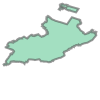

In [16]:
%%time

# Prompt the user for N_KT value
n_kt = input("De quelle région souhaitez-vous obtenir les résidents (par exemple, 'GE' ou 'VD'): ")

# Ask if we should include activities or just take the list of residents
include_activities = input("Voulez-vous inclure les activités dans la région {0} par des résidents d'autres cantons? (Oui/Non): ".format(n_kt))


# Unir les zones de trafic
N_KT_union = unary_union(TAZ[TAZ.N_KT == n_kt].geometry)

# Lister les résident·es du KT
list_residents_N_KT = dom.loc[dom.within(N_KT_union), 'IDNO'].tolist()

# Lister toutes les activités des résident·es du KT (incl. les activités hors KT)
list_act_N_KT_res = staypoints.loc[staypoints.user_id.isin(list_residents_N_KT), 'activity_id'].tolist()

if include_activities.lower() == 'oui':
    # Lister toutes les activités du KT (incl. activités des résident·es hors KT)
    activities_in_N_KT = staypoints.loc[staypoints.within(N_KT_union)]
    list_activities_in_N_KT = activities_in_N_KT.activity_id.tolist()

    # Merge the lists of activity IDs and drop duplicates
    list_staypoints_N_KT = list(set(list_act_N_KT_res) | set(list_activities_in_N_KT))
else:
    # Only take the list of residents
    list_staypoints_N_KT = list_act_N_KT_res
    activities_in_N_KT = staypoints.loc[(staypoints.activity_id.isin(list_act_N_KT_res))] #(staypoints.within(N_KT_union))
    activities_in_N_KT = activities_in_N_KT.dropna().loc[activities_in_N_KT.within(N_KT_union)]
    list_activities_in_N_KT = activities_in_N_KT.activity_id.tolist()

# Calculate the ratio of staypoints in the specified N_KT to total unique activities
ratio_staypoints_N_KT = len(list_staypoints_N_KT) / len(staypoints.activity_id.unique())

# Filter staypoints and legs for the specified N_KT
staypoints_N_KT = staypoints.loc[staypoints.activity_id.isin(list_staypoints_N_KT)].copy()
legs_N_KT = legs.loc[legs.next_activity_id.isin(list_staypoints_N_KT)].copy()

# Print the ratio of staypoints in the specified N_KT
print("\nRatio de points de séjour dans la région '{0}' par rapport aux activités uniques totales: {1:.2f}".format(n_kt, ratio_staypoints_N_KT))

# Print the normalized value counts of departure cantons for legs in the specified N_KT
print("\nValeurs normalisées des cantons d'origine pour les trajets dans la région '{0}':".format(n_kt))
print(legs_N_KT.canton_dep.value_counts(normalize=True))

# Print the number of activities recorded
print("\nNombre d'activités recensées :", len(legs_N_KT))

N_KT_union


In [17]:
# Indiquer quelles activités se passent dans KT (booléan) par quel résident·es (booléan)

staypoints_N_KT['user_residence_in_KT'] = 0
staypoints_N_KT['activity_in_KT'] = 0

staypoints_N_KT.loc[staypoints_N_KT.activity_id.isin(list_act_N_KT_res), 'user_residence_in_KT'] = 1
staypoints_N_KT.loc[staypoints_N_KT.activity_id.isin(list_activities_in_N_KT), 'activity_in_KT'] = 1

In [18]:
# Add the Municipality ID where the user lives
staypoints_N_KT = pd.merge(staypoints_N_KT, dom[['IDNO','dom_Typo_panel','dom_ID_COM']], left_on='user_id', right_on='IDNO', how='left')

# Add the Municipality ID where the activity occurs
staypoints_N_KT = gpd.sjoin(staypoints_N_KT, TAZ[['geometry','ID_Gem']], how='left', predicate="within")

# Rename columns for clarity
del staypoints_N_KT['index_right']
del staypoints_N_KT['IDNO']
staypoints_N_KT.rename(columns={'ID_Gem':'ID_Gem_activity', 'dom_Typo_panel':'Typo_user_home','dom_ID_COM':'ID_Gem_user_home'}, inplace=True)

# Recode the territorial typology
replacement_mapping = {
    'A': 'major_centers',
    'B': 'central_urban_areas',
    'C': 'urban_suburbs',
    'D': 'low_densities',
    'F': 'secondary_centers'
}

staypoints_N_KT['Typo_user_home'] = staypoints_N_KT['Typo_user_home'].replace(replacement_mapping)
staypoints_N_KT.loc[staypoints_N_KT.Typo_user_home.isna(), 'Typo_user_home'] = 'other'

# Sort values and parse data
staypoints_N_KT = staypoints_N_KT.sort_values(by=['user_id', 'started_date'])
staypoints_N_KT[['ID_Gem_activity', 'ID_Gem_user_home']] = staypoints_N_KT[['ID_Gem_activity', 'ID_Gem_user_home']].astype(int, errors='ignore')

In [19]:
len(staypoints_N_KT)

115047

### Visualize the data

In [20]:
%autoreload
xyt.plot_gps(staypoints_N_KT.dropna()[:2000], geo_columns='geometry')

In [21]:
staypoints_N_KT.columns

Index(['activity_id', 'started_at', 'finished_at', 'type',
       'started_at_timezone', 'purpose', 'user_id', 'geometry', 'started_date',
       'scattered_tracking', 'previous_leg_id', 'previous_mode', 'next_leg_id',
       'next_mode', 'lon', 'lat', 'previous_length', 'previous_duration',
       'next_length', 'next_duration', 'user_residence_in_KT',
       'activity_in_KT', 'Typo_user_home', 'ID_Gem_user_home',
       'ID_Gem_activity'],
      dtype='object')

In [22]:
staypoints_N_KT.activity_in_KT.value_counts()

activity_in_KT
1    68072
0    46975
Name: count, dtype: int64

In [122]:
staypoints_N_KT.dropna().user_id.unique()

array(['CH10223', 'CH10387', 'CH10443', 'CH10488', 'CH10497', 'CH10550',
       'CH1059', 'CH10599', 'CH10605', 'CH10631', 'CH10944', 'CH11059',
       'CH11120', 'CH1113', 'CH11161', 'CH11210', 'CH1123', 'CH11297',
       'CH11386', 'CH11471', 'CH11491', 'CH11492', 'CH11528', 'CH11734',
       'CH11735', 'CH1185', 'CH11870', 'CH11875', 'CH11932', 'CH11939',
       'CH11964', 'CH12232', 'CH12304', 'CH12350', 'CH12435', 'CH12515',
       'CH12635', 'CH12697', 'CH1270', 'CH12728', 'CH12747', 'CH12830',
       'CH12883', 'CH12947', 'CH12966', 'CH12973', 'CH1319', 'CH13233',
       'CH13377', 'CH13384', 'CH13467', 'CH13635', 'CH13743', 'CH13829',
       'CH13843', 'CH13922', 'CH1408', 'CH14110', 'CH14130', 'CH14132',
       'CH14137', 'CH14146', 'CH14191', 'CH1421', 'CH14215', 'CH14265',
       'CH14266', 'CH14289', 'CH143', 'CH14384', 'CH14438', 'CH14450',
       'CH14489', 'CH14512', 'CH14523', 'CH14636', 'CH14638', 'CH14685',
       'CH14784', 'CH14814', 'CH14851', 'CH14863', 'CH14939',

In [278]:
df_ = staypoints.loc[staypoints.user_id.isin(['CH3181'])]
df_.head()

,activity_id,started_at,finished_at,type,started_at_timezone,purpose,user_id,geometry,started_date,scattered_tracking,previous_leg_id,previous_mode,next_leg_id,next_mode,lon,lat,previous_length,previous_duration,next_length,next_duration
338607,75074f7e-43cf-45ba-85a1-870d3ef09a4e,2023-04-30 12:12:28,2023-05-01 05:10:22,Stay,Europe/Zurich,home,CH3181,POINT (6.53632 46.73239),2023-04-30,0,NaN,NaN,051d1613-b29a-4598-90d4-2365bf58132b,Mode::Car,6.536317,46.732394,NaN,NaN,5000.050975,356.0
338608,4311fb87-42d1-4950-b330-f06a18459bc1,2023-05-01 05:16:18,2023-05-01 15:11:05,Stay,Europe/Zurich,work,CH3181,POINT (6.56977 46.70299),2023-05-01,0,051d1613-b29a-4598-90d4-2365bf58132b,Mode::Car,92957703-71b4-4ae0-a1d2-3a2862d74a43,Mode::Car,6.569772,46.702987,5000.050975,356.0,5667.945060,543.0
338609,a274be2e-e5ea-46b2-a32a-32a711dca4e0,2023-05-01 15:20:08,2023-05-01 17:41:37,Stay,Europe/Zurich,home,CH3181,POINT (6.53626 46.73246),2023-05-01,0,92957703-71b4-4ae0-a1d2-3a2862d74a43,Mode::Car,eb7f73d0-bd61-4e8a-83cb-a2534f24bf08,Mode::Car,6.536256,46.732465,5667.945060,543.0,11475.316992,688.0
338610,11c2c50a-98b8-4608-924e-31644efaed2d,2023-05-01 17:53:05,2023-05-01 19:11:15,Stay,Europe/Zurich,family_friends,CH3181,POINT (6.61113 46.79128),2023-05-01,0,eb7f73d0-bd61-4e8a-83cb-a2534f24bf08,Mode::Car,67acd633-6f23-49c2-93d4-41605dcece2b,Mode::Car,6.611126,46.791278,11475.316992,688.0,11568.836714,788.0
338611,3111307b-2939-4ae3-b6dc-e54ba07ebfa6,2023-05-01 19:24:23,2023-05-02 05:13:13,Stay,Europe/Zurich,home,CH3181,POINT (6.53634 46.73237),2023-05-01,0,67acd633-6f23-49c2-93d4-41605dcece2b,Mode::Car,c3706323-1df1-49f4-b451-dbb4761234dd,Mode::Car,6.536341,46.732371,11568.836714,788.0,5722.308212,498.0


In [284]:
staypoints_N_KT.loc[staypoints_N_KT.user_id.isin(['CH3181'])]

,activity_id,started_at,finished_at,type,started_at_timezone,purpose,user_id,geometry,started_date,scattered_tracking,previous_leg_id,previous_mode,next_leg_id,next_mode,lon,lat,previous_length,previous_duration,next_length,next_duration,user_residence_in_KT,activity_in_KT,Typo_user_home,ID_Gem_user_home,ID_Gem_activity
83087,NaN,2023-05-07,2023-05-07,NaN,NaN,NaN,CH3181,None,2023-05-07,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,secondary_centers,5757.0,NaN
83088,NaN,2023-05-14,2023-05-14,NaN,NaN,NaN,CH3181,None,2023-05-14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,secondary_centers,5757.0,NaN
83089,NaN,2023-05-15,2023-05-15,NaN,NaN,NaN,CH3181,None,2023-05-15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,secondary_centers,5757.0,NaN
83090,NaN,2023-05-21,2023-05-21,NaN,NaN,NaN,CH3181,None,2023-05-21,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,secondary_centers,5757.0,NaN


In [279]:
df_.started_date.min()

Timestamp('2023-04-30 00:00:00')

In [280]:
df_.started_date.max()

Timestamp('2023-06-05 00:00:00')

In [281]:
df_.started_date.max() - df_.started_date.min()

Timedelta('36 days 00:00:00')

In [282]:
user_stat.columns

Index(['IDNO', 'created_at', 'activated_at', 'operating_system', 'os_version',
       'handset', 'first_tracked_at', 'latest_tracked_at',
       'latest_confirmed_finished_at', 'confirmed_tracks_count',
       'unconfirmed_tracks_count', 'tracks_count', 'unconfirmed_days_count',
       'active_days_count', 'days_in_range_count', 'confirmed_days_count',
       'inactive_days_count', 'latest_data_transmission_at',
       'latest_storyline_finished_at', 'created_at_in_timezone',
       'activated_at_in_timezone', 'first_tracked_at_in_timezone',
       'latest_tracked_at_in_timezone',
       'latest_confirmed_finished_at_in_timezone',
       'latest_data_transmission_at_in_timezone',
       'latest_storyline_finished_at_in_timezone'],
      dtype='object')

In [283]:
user_stat = pd.read_csv('../Data/dumps_fors/UserStatistics.EPFL-Panel.2023-04-24--2023-06-05.csv', sep=';')

user_stat.loc[user_stat.IDNO.isin(['CH3181']),['IDNO','first_tracked_at', 'latest_confirmed_finished_at','confirmed_days_count','inactive_days_count','days_in_range_count']]

,IDNO,first_tracked_at,latest_confirmed_finished_at,confirmed_days_count,inactive_days_count,days_in_range_count
0,CH3181,30.04.2023 12:12,2023-06-06 05:04:45.000,33,4,37


In [268]:
#user_stat[user_stat.inactive_days_count !=0]

In [235]:
user_stat

,id,email,created_at,activated_at,operating_system,os_version,handset,first_tracked_at,latest_tracked_at,friendly_user,latest_confirmed_finished_at,confirmed_tracks_count,unconfirmed_tracks_count,tracks_count,unconfirmed_days_count,active_days_count,days_in_range_count,registration_code,confirmed_days_count,inactive_days_count,latest_data_transmission_at,latest_storyline_finished_at,created_at_in_timezone,activated_at_in_timezone,first_tracked_at_in_timezone,latest_tracked_at_in_timezone,latest_confirmed_finished_at_in_timezone,latest_data_transmission_at_in_timezone,latest_storyline_finished_at_in_timezone
0,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,ligonin@bluewin.ch,2023-04-30 11:51:57.009,2023-04-30 12:03:03.216,android,11,samsung SM-G398FN,2023-04-30 12:12:28.585,2023-06-12 04:14:00.536,no,2023-06-06 05:04:45.000,210,0,210,0,33,37,nv58n,33,4,2023-06-12 04:54:03.303,2023-06-06 05:04:45.000,2023-04-30T11:51:57Z,2023-04-30T12:03:03Z,2023-04-30T12:12:28Z,2023-06-12T04:14:00Z,2023-06-06T05:04:45Z,2023-06-12T04:54:03Z,2023-06-06T05:04:45Z
1,001807b0-d393-47f1-be7d-a28708ab38b8,pamvgt@gmail.com,2023-05-02 16:35:21.741,2023-05-02 16:36:01.208,android,13,samsung SM-G781B,2023-05-04 16:57:22.457,2023-06-10 20:03:04.226,no,2023-06-06 08:12:39.000,21,0,21,0,18,35,v43d1,18,17,2023-06-11 14:03:26.999,2023-06-06 08:12:39.000,2023-05-02T16:35:21Z,2023-05-02T16:36:01Z,2023-05-04T16:57:22Z,2023-06-10T20:03:04Z,2023-06-06T08:12:39Z,2023-06-11T14:03:26Z,2023-06-06T08:12:39Z
2,0022452b-97e0-4e5f-b01e-1168e92364e6,zoechatagny@gmail.com,2023-04-24 19:09:16.447,2023-04-24 19:09:42.166,ios,iOS 15.5,"iPhone12,1",2023-04-24 19:11:20.385,2023-06-01 17:13:02.555,no,2023-04-25 12:48:58.000,4,280,284,38,39,43,x3n4s,1,4,2023-06-01 17:13:03.542,2023-06-01 16:49:20.000,2023-04-24T19:09:16Z,2023-04-24T19:09:42Z,2023-04-24T19:11:20Z,2023-06-01T17:13:02Z,2023-04-25T12:48:58Z,2023-06-01T17:13:03Z,2023-06-01T16:49:20Z
3,00284b1d-cc9c-46a7-9877-d5ab9aad7fd4,caroline.calpini@bluewin.ch,2023-04-25 09:17:27.192,2023-04-25 09:18:05.543,android,13,samsung SM-S906B,2023-05-02 15:49:07.967,2023-05-31 13:49:32.295,no,2023-05-31 05:11:36.000,269,1,270,1,24,42,a89mw,23,18,2023-05-31 14:23:27.258,2023-05-31 05:46:02.000,2023-04-25T09:17:27Z,2023-04-25T09:18:05Z,2023-05-02T15:49:07Z,2023-05-31T13:49:32Z,2023-05-31T05:11:36Z,2023-05-31T14:23:27Z,2023-05-31T05:46:02Z
4,00367e58-ad00-41db-b93b-1f1e55c5a733,arey@ik.me,2023-04-26 10:29:24.753,2023-05-10 05:44:10.649,ios,iOS 16.5,"iPhone11,8",2023-05-10 05:47:00.946,2023-06-12 10:02:11.598,no,2023-06-06 05:29:50.000,164,1,165,1,20,27,pndw4,19,7,2023-06-12 10:02:12.852,2023-06-06 05:29:50.000,2023-04-26T10:29:24Z,2023-05-10T05:44:10Z,2023-05-10T05:47:00Z,2023-06-12T10:02:11Z,2023-06-06T05:29:50Z,2023-06-12T10:02:12Z,2023-06-06T05:29:50Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,ffb32fa8-79c7-4360-9025-552fb8ca149b,melisa.shehu.a@gmail.com,2023-05-02 14:16:30.771,2023-05-02 14:16:45.677,ios,iOS 16.4.1,"iPhone13,3",2023-05-02 14:18:40.523,2023-06-02 20:44:46.996,no,2023-06-01 19:20:13.000,252,7,259,2,32,35,sf295,30,3,2023-06-02 20:47:22.806,2023-06-02 14:45:22.000,2023-05-02T14:16:30Z,2023-05-02T14:16:45Z,2023-05-02T14:18:40Z,2023-06-02T20:44:46Z,2023-06-01T19:20:13Z,2023-06-02T20:47:22Z,2023-06-02T14:45:22Z
3143,ffbe0b7f-d68e-43ca-9cb9-f9882882bd29,marianne.melo@bluewin.ch,2023-05-10 09:50:54.856,2023-05-10 13:49:48.277,NaN,NaN,NaN,NaN,NaN,no,NaN,0,0,0,0,0,27,y5b3m,0,27,NaN,NaN,2023-05-10T09:50:54Z,2023-05-10T13:49:48Z,NaN,NaN,NaN,NaN,NaN
3144,ffc1f825-f35b-4065-97c0-f761856c142d,maxime.luyet@gmail.com,2023-04-24 17:00:22.028,2023-04-24 17:01:22.795,android,13,samsung SM-A715F,2023-04-24 17:06:09.335,2023-06-12 08:47:22.786,no,2023-06-02 18:05:45.000,407,9,416,3,39,43,gn234,36,4,2023-06-12 09:42:50.228,2023-06-07 16:38:14.000,2023-04-24T17:00:22Z,2023-04-24T17:01:22Z,2023-04-24T17:06:09Z,2023-06-12T08:47:22Z,2023-06-02T18:05:45Z,2023-06-12T09:42:50Z,2023

In [203]:
metrics = xyt.GPSAnalytics()

In [204]:
df = metrics.split_overnight(df_)
# DAILY USER_ID: Add user_ids per day
df.insert(
    1,
    "user_id_day",
    df["user_id"]
    + "_"
    + df.started_at.dt.year.astype(str)
    + df.started_at.dt.month.astype(str).str.zfill(2)
    + df.started_at.dt.day.astype(str).str.zfill(2),
)
df.head(3)

,activity_id,user_id_day,started_at,finished_at,type,started_at_timezone,purpose,user_id,geometry,started_date,scattered_tracking,previous_leg_id,previous_mode,next_leg_id,next_mode,lon,lat,previous_length,previous_duration,next_length,next_duration,user_residence_in_KT,activity_in_KT,Typo_user_home,ID_Gem_user_home,ID_Gem_activity,duration
0,42761e86-e0b8-47d9-b1f7-3d533f720639,CH10223_20230502,2023-05-02 13:26:02,2023-05-02 15:26:39,Stay,Europe/Zurich,leisure,CH10223,POINT (6.146636759801854 46.201355363785396),2023-05-02,0,NaN,NaN,817ce693-f3ef-4293-81b2-6182b63318ed,Mode::Bicycle,6.146637,46.201355,NaN,NaN,592.986965,117.0,1,0,major_centers,6621.0,6621.0,120.616667
1,6c3eb9f4-9ac0-4923-9eb6-2d1968d0b9ef,CH10223_20230502,2023-05-02 15:28:36,2023-05-02 15:31:44,Stay,Europe/Zurich,wait,CH10223,POINT (6.143796355457694 46.203754856511985),2023-05-02,0,817ce693-f3ef-4293-81b2-6182b63318ed,Mode::Bicycle,221d25f5-f795-4d18-8632-3e691120a0f6,Mode::Walk,6.143796,46.203755,592.986965,117.0,359.358185,197.0,1,1,major_centers,6621.0,6621.0,3.133333
2,0397bc29-ce0f-401b-a761-5ea59d28c040,CH10223_20230502,2023-05-02 15:35:01,2023-05-02 17:29:34,Stay,Europe/Zurich,shopping,CH10223,POINT (6.141650359661825 46.20487190743875),2023-05-02,0,221d25f5-f795-4d18-8632-3e691120a0f6,Mode::Walk,77f7fe83-bc99-40f3-bb7f-573c2cef5341,Mode::Walk,6.141650,46.204872,359.358185,197.0,1222.062332,984.0,1,1,major_centers,6621.0,6621.0,114.550000


In [222]:
def get_modal_distances(df):

    df['previous_length'] = df['previous_length'].astype(float)
    # Group by 'user_id_day', 'previous_mode', and 'previous_leg_id', then sum the distances
    grouped = df.groupby(['user_id','user_id_day', 'previous_mode'])['previous_length'].sum().reset_index()

    # Pivot the table to have modes as columns
    pivoted = grouped.pivot_table(
        index=['user_id','user_id_day'],
        columns='previous_mode',
        values='previous_length',
        aggfunc='sum'
    ).reset_index()

    # Resample to include missing days and fill NaNs with different values in different columns
    pivoted['date'] = pd.to_datetime(pivoted['user_id_day'].str[-8:])
    # Create a date range covering the entire date range for each ID
    date_ranges = pivoted.groupby('user_id')['date'].agg(['min', 'max']).reset_index()
    date_ranges['started_date'] = date_ranges.apply(lambda row: pd.date_range(row['min'], row['max'], freq='D'), axis=1)
    
    # Create a Cartesian product of IDs and date ranges
    cartesian = date_ranges.explode('started_date').reset_index(drop=True)
    #
    # Complete the original df with a continuous timeline
    pivoted_filled = pd.merge(pivoted, cartesian[['user_id', 'started_date']], how='outer', left_on=['user_id', 'date'], right_on=['user_id', 'started_date'])
    del pivoted_filled['started_date']

    
    # Fill missing values in the modes columns
    modes_columns = ['Mode::Airplane', 'Mode::Bicycle', 'Mode::Bus', 'Mode::Car', 'Mode::Train', 'Mode::Tram', 'Mode::Walk']
    for col in modes_columns:
        pivoted_filled[col] = pivoted_filled[col].fillna(0)  # Fill NaN values with 0 for the modes
    
    # Sort the resulting DataFrame
    pivoted_filled.sort_values(by=['user_id', 'date'], inplace=True)
    
    return pivoted_filled



In [226]:
get_modal_distances(df)

,user_id,user_id_day,Mode::Airplane,Mode::Bicycle,Mode::Bus,Mode::Car,Mode::Train,Mode::Tram,Mode::Walk,date
0,CH10223,CH10223_20230502,0.000000,592.986965,0.000000,0.000000,0.000000,0.000000,1581.420517,2023-05-02
1,CH10223,CH10223_20230503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3192.979024,2023-05-03
2,CH10223,CH10223_20230504,0.000000,6360.528272,0.000000,0.000000,0.000000,0.000000,4802.669707,2023-05-04
3,CH10223,CH10223_20230505,0.000000,4367.566266,0.000000,0.000000,0.000000,0.000000,2802.400877,2023-05-05
4,CH10223,CH10223_20230506,432049.397773,1800.700161,0.000000,42371.571595,0.000000,0.000000,3031.014412,2023-05-06
5,CH10223,CH10223_20230507,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7377.929316,2023-05-07
6,CH10223,CH10223_20230508,0.000000,0.000000,4268.469470,3571.129110,0.000000,0.000000,2016.511140,2023-05-08
7,CH10223,CH10223_20230509,0.000000,0.000000,777.537781,0.000000,227249.218326,0.000000,2134.768034,2023-05-09
8,CH10223,CH10223_20230510,0.000000,0.000000,0.000000,0.000000,0.000000,1352.744662,5566.887711,2023-05-10
9,CH10223,CH10223_20230511,0.000000,0.000000,0.000000,0.000000,0.000000,4215.203025,2714.485200,2023-05-11


In [ ]:
#Check if the code works
df.loc[(df.previous_mode == 'Mode::Walk') & (df.user_id_day == 'CH10223_20230502')]

### Drop some duplicates and Compute and save the distance indicators

In [31]:
distances_N_KT = staypoints_N_KT[['activity_id', 'purpose', 'user_id', 
                              'previous_leg_id', 'scattered_tracking', 'started_at', 'finished_at', 'started_date', 
                              'user_residence_in_KT', 'activity_in_KT', 'Typo_user_home', 'ID_Gem_user_home', 'ID_Gem_activity']].copy()

In [32]:
%%time

distances_N_KT = pd.merge(distances_N_KT, legs_N_KT[['detected_mode', 'mode', 'canton_dep',
       'low_quality_legs_1', 'low_quality_legs_2','next_activity_id', 'length', 'duration']].dropna(subset='next_activity_id'),
                       left_on='activity_id',right_on='next_activity_id', how='left')
del distances_N_KT['next_activity_id']

CPU times: user 74.4 ms, sys: 22.7 ms, total: 97.1 ms
Wall time: 97.6 ms


In [33]:
distances_N_KT

,activity_id,purpose,user_id,previous_leg_id,scattered_tracking,started_at,finished_at,started_date,user_residence_in_KT,activity_in_KT,Typo_user_home,ID_Gem_user_home,ID_Gem_activity,detected_mode,mode,canton_dep,low_quality_legs_1,low_quality_legs_2,length,duration
0,NaN,NaN,CH02,NaN,0,2023-05-14,2023-05-14,2023-05-14,1,0,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,CH02,NaN,0,2023-05-21,2023-05-21,2023-05-21,1,0,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,CH02,NaN,0,2023-05-28,2023-05-28,2023-05-28,1,0,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,CH02,NaN,0,2023-06-03,2023-06-03,2023-06-03,1,0,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,CH02,NaN,0,2023-06-04,2023-06-04,2023-06-04,1,0,other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115074,NaN,NaN,FR9994,NaN,1,2023-05-26,2023-05-26,2023-05-26,1,0,low_densities,74216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115075,NaN,NaN,FR9994,NaN,1,2023-05-27,2023-05-27,2023-05-27,1,0,low_densities,74216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115076,NaN,NaN,FR9994,NaN,1,2023-05-28,2023-05-28,2023-05-28,1,0,low_densities,74216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115077,NaN,NaN,FR9994,NaN,1,2023-05-29,2023-05-29,2023-05-29,1,0,low_densities,74216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Reimport file for delivered to Canton an merge it to my file

In [28]:
%%time 

pickle_file_path = "staypoints_filtered_with_sociodemo_withoutIDNO.pkl"
sociodemo = pd.read_pickle(pickle_file_path)

#Get all the pseudo user_ids
#pseudo = staypoints[['activity_id','user_id']].drop_duplicates().dropna().merge(
#    sociodemo[['id','jointure_g']].drop_duplicates().dropna(),
#    left_on='activity_id', right_on='id', how='left')[['user_id','jointure_g']].drop_duplicates()
#pseudo.rename(columns={'jointure_g':'user_id_pseudo', 'user_id':'IDNO'}, inplace=True)
#pseudo.to_pickle(f'pseudo_user_ids.pkl')
pseudo = pd.read_pickle('pseudo_user_ids.pkl')

IDNO_info = pd.read_pickle('days_of_observation.pkl')

CPU times: user 1.36 s, sys: 411 ms, total: 1.77 s
Wall time: 1.79 s


In [29]:
IDNO_info = IDNO_info.merge(pseudo, on='IDNO', how='left')
distances_N_KT = distances_N_KT.merge(IDNO_info, left_on='user_id', right_on='IDNO', how='left')

In [36]:
%%time

distances_N_KT = distances_N_KT.dropna(subset='user_id_pseudo').merge(sociodemo[['jointure_g','gdr', 'age', 'educ_ch', 'educ_fr', 'prof', 'wgt_cant_t', 'wgt_agg_tr']], left_on='user_id_pseudo', right_on='jointure_g', how='left')
del distances_N_KT['jointure_g']
del sociodemo
del distances_N_KT['IDNO']

distances_N_KT.rename(columns={'gdr':'genre'}, inplace=True)

CPU times: user 18.8 s, sys: 25 s, total: 43.7 s
Wall time: 52.6 s


In [37]:
distances_N_KT = distances_N_KT.dropna(subset='activity_id').sort_values(by=['user_id', 'started_date', 'length'])
distances_N_KT.drop_duplicates(subset='activity_id', keep='last', inplace=True)

In [38]:
#loss compared to ariginal staypoint df
1- len(distances_N_KT) / len(staypoints_N_KT)

0.12228326550343283

In [39]:
#Cheeck for duplicates
distances_N_KT[distances_N_KT.duplicated('activity_id')]

,activity_id,purpose,user_id,previous_leg_id,scattered_tracking,started_at,finished_at,started_date,user_residence_in_GE,activity_in_GE,Typo_user_home,ID_Gem_user_home,ID_Gem_activity,detected_mode,mode,canton_dep,low_quality_legs_1,low_quality_legs_2,length,duration,Min Date,Max Date,Track duration,Number of observation,Missing Dates,Max Gap Between Days,user_id_pseudo,genre,age,educ_ch,educ_fr,prof,wgt_cant_t,wgt_agg_tr


### Temporary saves

In [41]:
# Save whole file
distances_N_KT.to_pickle(f'temp_files/distances_N_KT.pkl')
legs_N_KT.to_pickle(f'temp_files/legs_N_KT.pkl')

In [42]:
# Read the entire pickle file into memory
distances_N_KT = pd.read_pickle('temp_files/distances_N_KT.pkl')
legs_N_KT = pd.read_pickle('temp_files/legs_N_KT.pkl')

In [43]:
distances_N_KT.columns

Index(['activity_id', 'purpose', 'user_id', 'previous_leg_id',
       'scattered_tracking', 'started_at', 'finished_at', 'started_date',
       'user_residence_in_GE', 'activity_in_GE', 'Typo_user_home',
       'ID_Gem_user_home', 'ID_Gem_activity', 'detected_mode', 'mode',
       'canton_dep', 'low_quality_legs_1', 'low_quality_legs_2', 'length',
       'duration', 'Min Date', 'Max Date', 'Track duration',
       'Number of observation', 'Missing Dates', 'Max Gap Between Days',
       'user_id_pseudo', 'genre', 'age', 'educ_ch', 'educ_fr', 'prof',
       'wgt_cant_t', 'wgt_agg_tr'],
      dtype='object')

In [63]:
import pandas as pd

# Custom aggregation function to calculate the ratio
def ratio(series):
    total_low_quality = series.sum()
    total_trips = len(series)
    return total_low_quality / total_trips

# Create an ExcelWriter object to save multiple DataFrames to different tabs
with pd.ExcelWriter('temp_files/distances_N_KT_panel.xlsx', engine='xlsxwriter') as writer:
    aggreg_cols = {
        'TYPO_territoire_de_residence': 'Typo_user_home',
        'KT_territoire_de_residence': 'canton_dep'
    }

    for sheet_name, aggreg_col in aggreg_cols.items():
        # Group by user_id, mode, and purpose
        grouped_df = distances_N_KT[['user_residence_in_N_KT', 'activity_in_N_KT', 'mode', 'purpose','length', 'user_id_pseudo', 'started_date', 'duration', 'low_quality_legs_1', 'low_quality_legs_2', 'genre', 'age', 'educ_fr', 'educ_ch', 'prof','wgt_cant_t','wgt_agg_tr'] + [aggreg_col]].groupby(['user_residence_in_N_KT', 'activity_in_N_KT', 'mode', 'purpose', 'user_id_pseudo'] + [aggreg_col])
                
        result_df = grouped_df.agg({
            'length': ['sum', 'count'],
            'started_date': 'nunique',
            'duration': 'sum',
            'low_quality_legs_1': ratio, 
            'low_quality_legs_2': ratio,
            'genre': 'first',
            'age': 'first',
            'educ_fr': 'first',
            'educ_ch': 'first',
            'prof': 'first',
            'wgt_cant_t': 'first',
            'wgt_agg_tr': 'first',
        }).reset_index()

        # Flatten the MultiIndex columns
        result_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in result_df.columns]

        # Save the result_df to a new Excel tab
        result_df.to_excel(writer, sheet_name=sheet_name, index=False)

    # Add the additional sheet
    additional_sheet_df = distances_N_KT[['user_id_pseudo', 'Min Date', 'Max Date', 'Track duration', 'Number of observation', 'Missing Dates', 'Max Gap Between Days']].drop_duplicates().reset_index(drop=True).rename(columns={'Number of observation': 'Days with tracking'})
    additional_sheet_df.to_excel(writer, sheet_name='Jours_enquete_par_enquete', index=False)


In [45]:
distances_N_KT.loc[(distances_N_KT.Typo_user_home == 'central_urban_areas') & (distances_N_KT.user_residence_in_N_KT == 1), 'mode'].unique()

array([nan, 'Mode::Walk', 'Mode::Bicycle', 'Mode::Tram', 'Mode::Car',
       'Mode::Bus', 'Mode::Airplane', 'Mode::Ecar', 'Mode::Carsharing',
       'Mode::Train', 'Mode::Motorbike', 'Mode::Ebicycle', 'Mode::Subway',
       'Mode::KickScooter', 'Mode::Other', 'Mode::RegionalTrain',
       'Mode::TaxiUber', 'Mode::LightRail', 'Mode::Boat'], dtype=object)

In [66]:
len(result_df.user_id_pseudo.unique())

1518

In [47]:
result_df['length_sum_per_day'] = result_df['length_sum'] / 1000 / result_df['started_date_nunique']
result_df[result_df.user_residence_in_N_KT == 1].groupby(['mode']).agg({'length_sum_per_day':'mean'})

,length_sum_per_day
mode,
Mode::Airplane,1197.721472
Mode::Bicycle,4.580163
Mode::Bikesharing,3.290810
Mode::Boat,39.923134
Mode::Bus,3.525734
Mode::Car,22.013794
Mode::Carsharing,23.079008
Mode::Ebicycle,4.022240
Mode::Ecar,21.141736


In [58]:
distances_N_KT[['user_id_pseudo','Min Date', 'Max Date', 'Track duration','Number of observation', 'Missing Dates', 'Max Gap Between Days']].drop_duplicates().reset_index(drop=True).rename(columns={'Number of observation':'Days with tracking'})

,user_id_pseudo,Min Date,Max Date,Track duration,Days with tracking,Missing Dates,Max Gap Between Days
0,2,2023-04-24 18:45:46,2023-05-31 12:40:27,38,37,1,3.0
1,5,2023-05-02 17:02:15,2023-05-30 20:07:02,30,23,7,7.0
2,7,2023-04-24 21:52:41,2023-06-05 16:15:30,43,43,0,1.0
3,11,2023-04-24 16:10:48,2023-06-05 14:42:53,43,43,0,1.0
4,14,2023-05-02 17:45:58,2023-06-05 15:43:07,35,35,0,1.0
...,...,...,...,...,...,...,...
1521,2621,2023-04-25 16:18:51,2023-06-05 16:24:10,43,41,2,1.0
1522,2622,2023-05-03 18:47:27,2023-06-05 18:21:08,34,15,19,7.0
1523,2623,2023-04-24 21:03:59,2023-06-03 11:16:10,41,38,3,3.0
1524,2624,2023-05-12 15:53:38,2023-06-05 21:02:26,26,25,1,1.0


In [50]:
distances_N_KT.columns

Index(['activity_id', 'purpose', 'user_id', 'previous_leg_id',
       'scattered_tracking', 'started_at', 'finished_at', 'started_date',
       'user_residence_in_GE', 'activity_in_GE', 'Typo_user_home',
       'ID_Gem_user_home', 'ID_Gem_activity', 'detected_mode', 'mode',
       'canton_dep', 'low_quality_legs_1', 'low_quality_legs_2', 'length',
       'duration', 'Min Date', 'Max Date', 'Track duration',
       'Number of observation', 'Missing Dates', 'Max Gap Between Days',
       'user_id_pseudo', 'genre', 'age', 'educ_ch', 'educ_fr', 'prof',
       'wgt_cant_t', 'wgt_agg_tr'],
      dtype='object')